# Previsão de Demanda de Vinhos com Séries Temporais

A **Previsão de Demanda** é um processo crucial para as empresas, pois **visa antecipar a disposição dos clientes em adquirir um produto a um determinado preço**. Para realizar essa previsão, são analisados dados históricos de vendas e levados em consideração diversos fatores que podem influenciar a demanda futura de um produto. A previsão de demanda abrange aspectos como elaboração de orçamentos, planejamento e preparação da produção, gestão de estoques, definição de preços e promoções, entre outros.

<p align = "center">
<img src="Arquivos/wine.jpg" width=80%>
</p>

O **objetivo** deste projeto é **realizar a previsão das vendas de vinhos utilizando séries temporais**. As séries temporais são conjuntos de dados coletados em intervalos regulares de tempo, permitindo observar padrões, sazonalidades e tendências ao longo do tempo. No caso deste projeto, serão analisados **dados sintéticos** baseados em uma competição do *Kaggle*.

Os **vinhos** são bebidas que evoluem continuamente, **exigindo condições ideais de armazenamento e transporte** para preservar suas características e evitar a deterioração. Por esse motivo, é essencial ter cuidado especial com a guarda e o transporte dos vinhos, de modo a ****minimizar perdas no estoque e maximizar o lucro da empresa**.

Embora alguns vinhos possam melhorar com o passar dos anos, a maioria é produzida para consumo "imediato", desde o momento em que chegam ao mercado até, no máximo, 1 a 3 anos. Portanto, é fundamental evitar o acúmulo de vinhos no estoque, otimizando o gerenciamento de demanda e garantindo a satisfação do cliente, bem como a saúde financeira da empresa.

## Aquisição dos Dados

Há dois arquivos disponíveis, baseados no *Kaggle*, criados pelo Rafael Duarte, que serão analisados. O primeiro disponível [aqui](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv) trata de informações sobre o produto. A primeira análise será sobre o mesmo a fim de entender melhor o rpoblema.

O próximo conjunto de dados é relacionado às vendas, disponível [aqui](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv). Neste conjunto é onde será utilizado a série temporal com o objetivo de prever a demanda.

In [72]:
# Importação de bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')

# Importando o Prophet
from prophet import Prophet
from prophet.plot import plot_plotly

import plotly.offline as pyo
import logging

logging.getLogger().setLevel(logging.ERROR)

# Métricas do Scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [73]:
# importar os dados
df_product = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv")

store = pd.read_csv("https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv")

## Análise dos Dados

Esta etapa tem por objetivo permitir um entendimento de como os dados estão estruturados.

**Dicionário das variáveis**

* `item_id`- Número de identificação do item
* `name`- Nome do vinho
* `producer`- Nome do Produtor do vinho
* `country`- País de origem do vinho
* `vintage`- Safra
* `kind`- Tipo do vinho
* * Sparkling = Espumante
* * Rose Sparkling = Espumante Rose
* * White = Branco
* * Rosé = Rosé
* * Red = Tinto
* `price_brl`- Preço em reais
* `price_usd`- Preço em dólar americano

## Análise Exploratória dos Dados

Na análise exploratória de dados será efetuada uma explanação inicial das variáveis contidas na dataset.


Primeiramente, observaremos como estão dispostas as cinco primeiras entradas do dataset para ter uma visão ampla da estrutura de dados.

In [74]:
df_product.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


In [75]:
# Visualizar o tamanho do dataframe
print("Entradas: ", df_product.shape[0])
print("Variáveis: ", df_product.shape[1])

Entradas:  219
Variáveis:  9


In [76]:
# Extrair o nome das colunas
df_product.columns

Index(['item_id', 'name', 'producer', 'country', 'region', 'vintage', 'kind',
       'price_brl', 'price_usd'],
      dtype='object')

O dataset contém **219 instâncias** e **9 features**. Observando as 5 primeiras entradas é possível identificar alguns problemas que devem ser corrigidos:

* A feature "price_brl" possui algumas vírgulas, que não vão ser bem interpretadas pelo Python.
* A safra, ou vintage, possui valores como NV (Non-Vintage) que devem ser alterados para 0.

Corrigiremos estes problemas a seguir.

In [77]:
# limpando as vírgulas
df_product.replace(',','', regex=True, inplace=True)
# removendo o NV da safra
df_product.vintage = df_product.vintage.replace('NV', '0')
df_product.vintage = pd.to_numeric(df_product.vintage)
# visualizando o dataset
df_product.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,0,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.00,267.82


Verificaremos agora a porcentagem de itens nulos.

In [78]:
# porcentagem de itens nulo
(df_product.isnull().sum()/df_product.shape[0]).sort_values(ascending = True)

item_id      0.0
name         0.0
producer     0.0
country      0.0
region       0.0
vintage      0.0
kind         0.0
price_brl    0.0
price_usd    0.0
dtype: float64

O dataset possui não possui dados ausentes. Veremos agora o tipo das variáveis.

In [79]:
df_product.dtypes

item_id       int64
name         object
producer     object
country      object
region       object
vintage       int64
kind         object
price_brl    object
price_usd    object
dtype: object

 As variáveis `price_brl` e `price_usd` estão como string, irei as converter para float.

In [80]:
# conversão para float
df_product.vintage = df_product.vintage.astype(int)
df_product.price_brl = df_product.price_brl.astype(float)
df_product.price_usd = df_product.price_usd.astype(float)

Verificaremos novamente os tipos para confirmar que a mudança foi efetuada.

In [81]:
df_product.dtypes

item_id        int64
name          object
producer      object
country       object
region        object
vintage        int32
kind          object
price_brl    float64
price_usd    float64
dtype: object

Verificaremos a quantidade de **produtores** de vinhos no dataset e plotaremos um gráfico de barras.

In [82]:
df_product.producer.value_counts()

Domaine Ponsot                                    12
La Chablisienne                                   10
Domaine Matrot                                     9
Achaval Ferrer                                     8
Pêra-Grave                                         8
Olivier Riviere                                    8
Casanova di Neri                                   8
Eric Texier                                        7
Domaine Pascal Prunier-Bonheur                     7
Domaine Tessier                                    5
Luis Seabra Vinhos                                 5
Aalto                                              5
Sandrone                                           5
Domaine de Fontbonau                               5
Philipponat                                        5
Domaine Michel Niellon                             5
Domaine Alain Chavy                                5
Chateau Pavie                                      4
Agrapart                                      

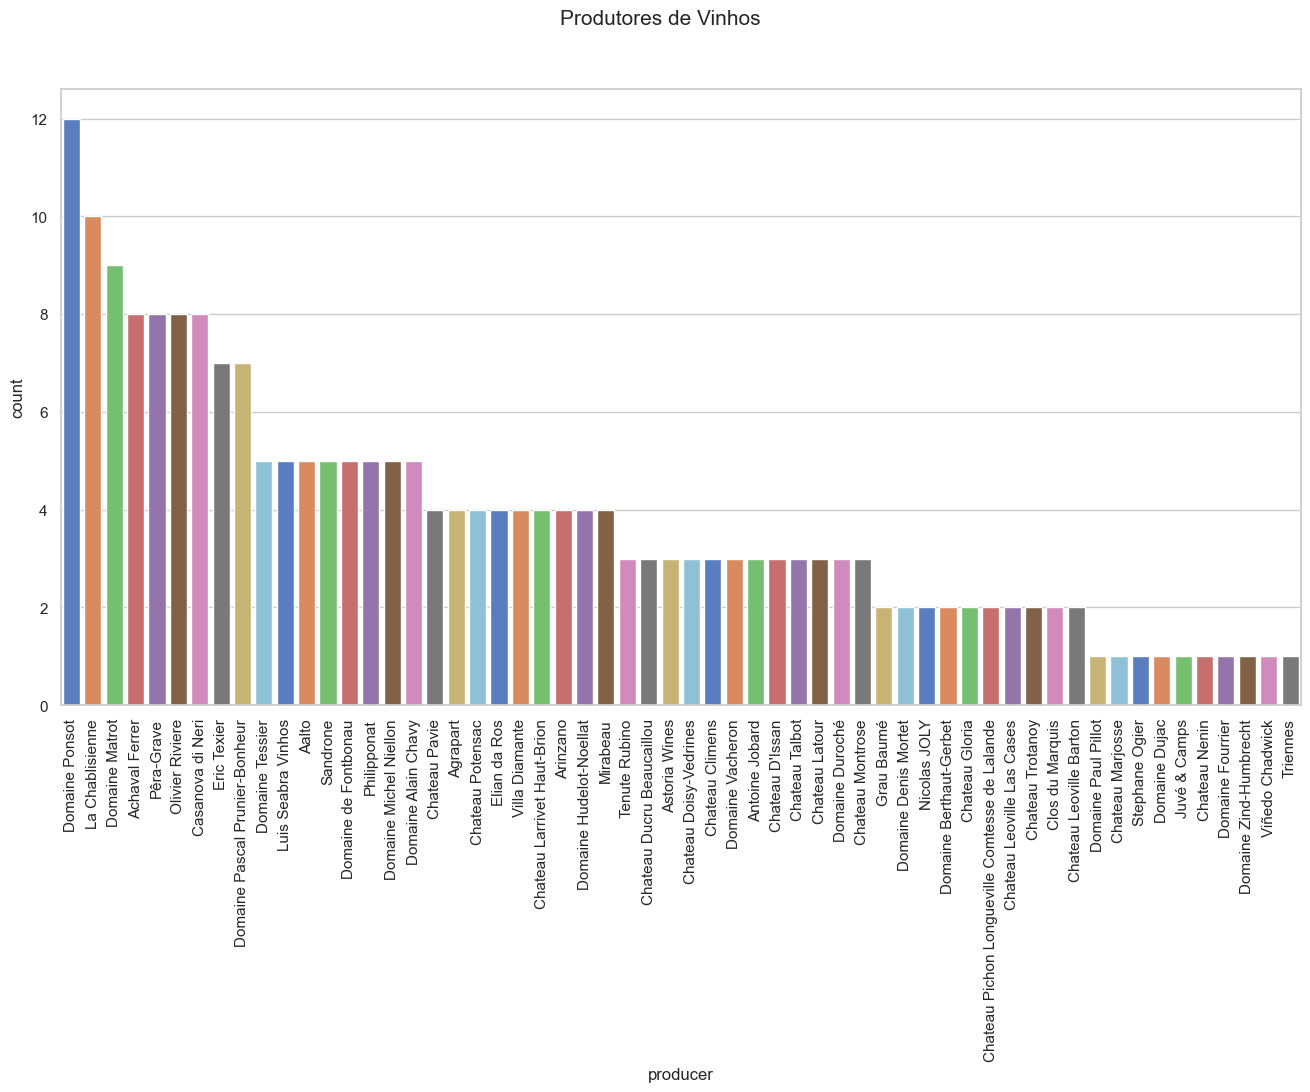

In [83]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(x=df_product.producer, order=df_product.producer.value_counts().index, palette = sns.color_palette("muted"));
plt.xticks(rotation=90)
fig.suptitle("Produtores de Vinhos", fontsize = 15)
plt.show();

Veremos agora a **quantidade de vinhos por país**.

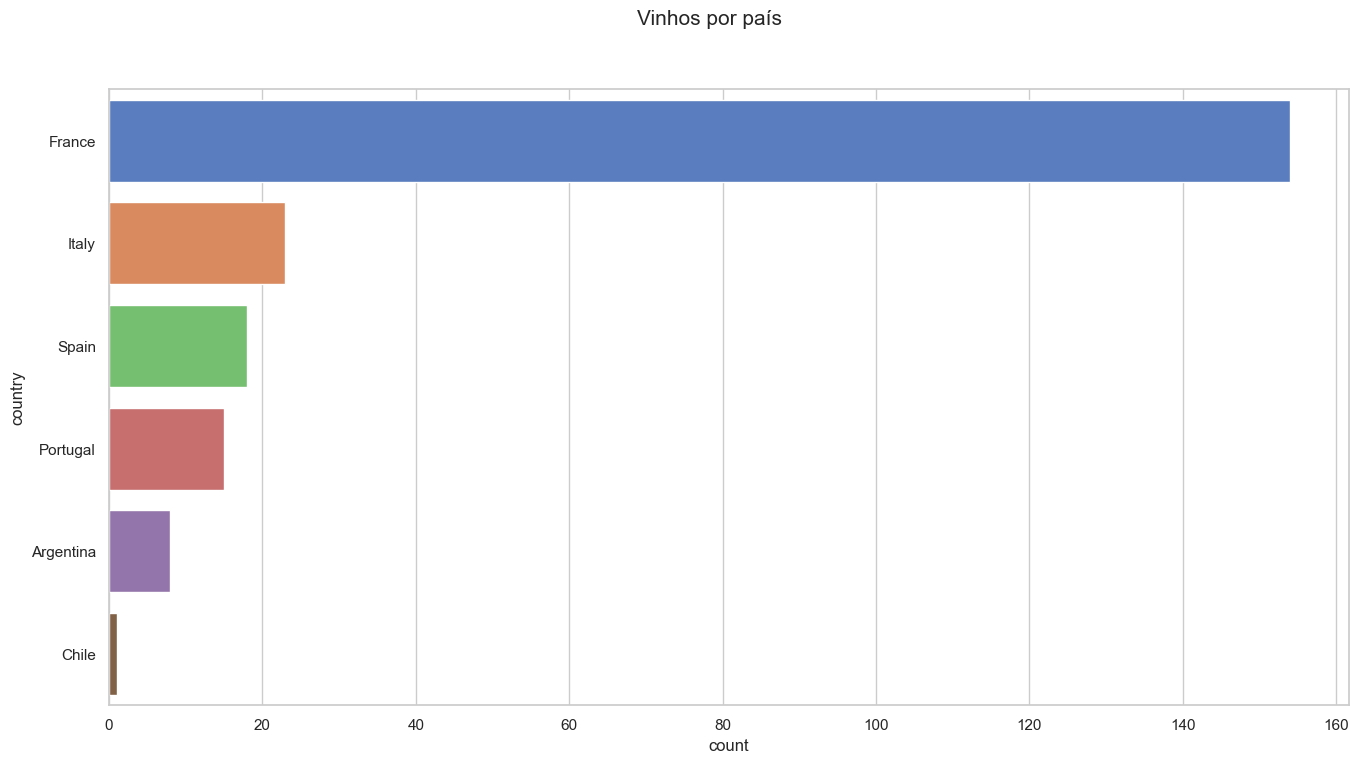

In [84]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(y=df_product.country, order=df_product.country.value_counts().index, palette = sns.color_palette("muted"));
fig.suptitle("Vinhos por país", fontsize = 15)
plt.show();

No dataset o país prevalecente é **França**, seguido de **Itália** e **Espanha**.

Veremos agora a maior quantidade de vinhos por região.

In [85]:
df_product.region.value_counts()

Burgundy            70
Bordeaux            47
Rhone               13
Champagne            9
Alentejo             8
Rioja                8
Toscana              8
Mendoza              8
Douro                7
Provence             5
Ribera del Duero     5
Loire Valley         5
Piedmont             5
Sud Ouest            4
Campania             4
Navarra              4
Veneto               3
Puglia               3
Alsace               1
Penedès              1
Maipo                1
Name: region, dtype: int64

As regiões prevalecentes são **Burgundy**, **Bordeaux**, **Rhone** e **Champagne**.

Veremos agora a safra com maior quantidade de vinhos por **safra**, exluindo aqueles que não possuem safra identificada.

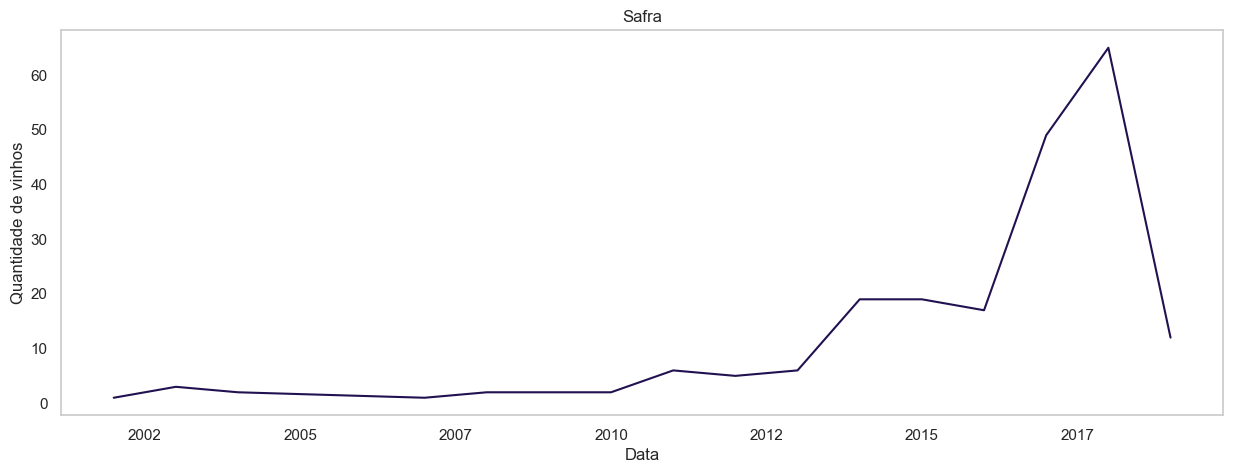

In [86]:
df_copy = df_product.loc[df_product.vintage != 0]

fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.set(style="whitegrid", palette = 'magma')

ax = sns.lineplot(
    x=df_copy.vintage.value_counts().index, y=df_copy.vintage.value_counts().values,
);

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.grid(False)
ax.set(xlabel='Data', ylabel='Quantidade de vinhos')
ax.set_title("Safra")
plt.show()

Pode-se observar que no dataset, há maiores quantidades de vinhos a partir da safra de 2015.

Vejamos também a quantidade por tipos de vinhos.

In [87]:
df_product.kind.value_counts()

red               132
white              69
sparkling          10
rose                5
rose sparkling      3
Name: kind, dtype: int64

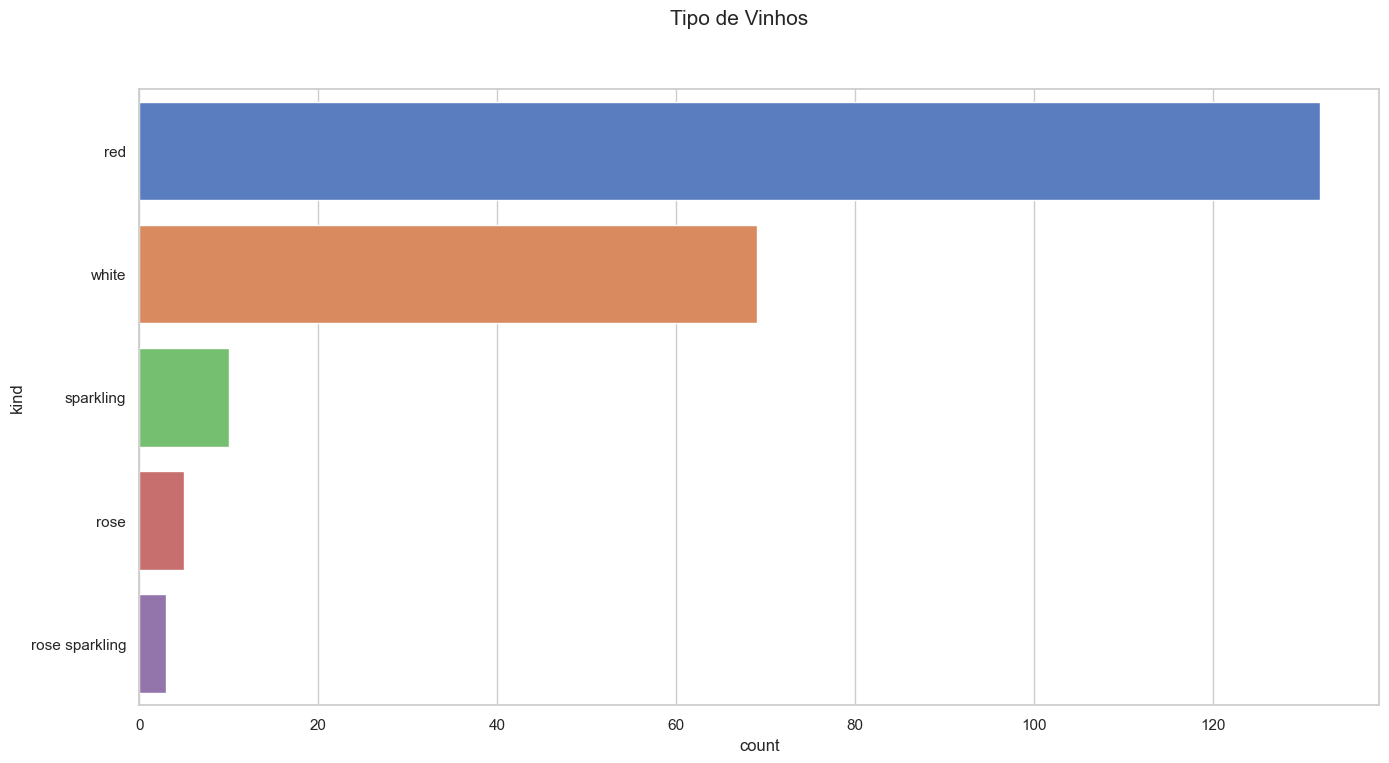

In [88]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(y=df_product.kind, order=df_product.kind.value_counts().index, palette = sns.color_palette("muted"));
fig.suptitle("Tipo de Vinhos", fontsize = 15)
plt.show();

No dataset, há maior prevalência de vinhos **tintos**, **brancos** e **espumante**.

Iremos observar informações estatísticas do dataset.

In [89]:
df_product[['vintage', 'price_brl', 'price_usd']].describe()

,vintage,price_brl,price_usd
count,219.000000,219.000000,219.000000
mean,1942.182648,967.617352,167.407808
std,379.055337,1409.588217,243.873780
min,0.000000,52.800000,9.130000
25%,2014.000000,264.300000,45.725000
50%,2017.000000,509.400000,88.130000
75%,2018.000000,949.200000,164.220000
max,2019.000000,10992.000000,1901.730000


Pode-se observar que:
    
* A mediana da safra está em 2017 e o valor máximo em 2019.
* O preço mínimo é 52 reais e o máximo 10.992.

Observaremos um boxplot do preço de vinhos.

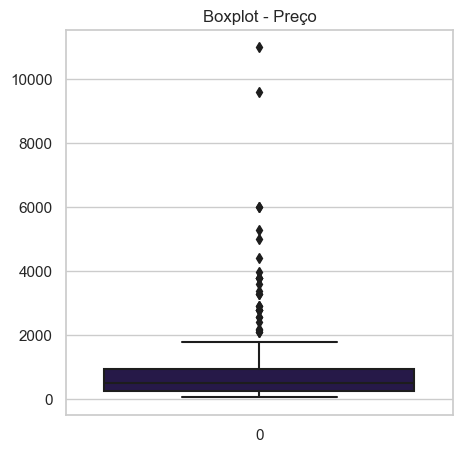

In [90]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette("magma")
sns.boxplot(df_product.price_brl, ax = ax);
ax.set_title("Boxplot - Preço");

Há alguns **outliers** referente ao **preço**. Agruparemos os vinhos mais caros por tipo, e o top 5 de vinhos mais caros.

In [91]:
# vinhos mais caros por tipos
df_product.groupby(['kind']).price_brl.max().sort_values(ascending = False)

kind
red               10992.0
white              3294.0
sparkling          1548.0
rose sparkling      899.4
rose                285.0
Name: price_brl, dtype: float64

Os vinhos com preço maior são tintos, brancos e espumante, respectivamente.

In [92]:
# top 5 vinhos mais caros
df_product.sort_values('price_brl', ascending = False)[:5]

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
93,94,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,10992.0,1901.73
116,117,Latour,Chateau Latour,France,Bordeaux,2002,red,9594.0,1659.86
142,143,Château Pavie,Chateau Pavie,France,Bordeaux,2010,red,5999.4,1037.96
91,92,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2007,red,5994.0,1037.02
92,93,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,5292.0,915.57


O vinho mais caro custa **10.992** reais, chamado *Domaine Ponsot Clos de La Roche*, da **França**, região de *Burgundy* da safra de **2017**. 

Visualizaremos agora os dados referentes às vendas. Para isso, irei unir o dataframe **store**, com o dataframe previamente analisado. 

In [93]:
store.rename(columns= {'item': 'item_id'}, inplace=True)
store.item_id = store.item_id.astype(str)

df_product['item_id'] = df_product['item_id'].astype(str)
store = df_product.merge(store, on='item_id', how='right')

store['date'] = pd.to_datetime(store['date'])
store.index = store['date']
store.drop('date', axis=1, inplace=True)

print(store.shape)
store.head()

(720071, 11)


,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales
date,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10


Iremos agora verificar as informações estatísticas dos dados.

In [94]:
# distribuição estatística das vendas
round(store.describe(),2)

,vintage,price_brl,price_usd,store,sales
count,720071.00,720071.00,720071.00,720071.00,720071.00
mean,1942.18,967.62,167.41,2.00,70.59
std,378.19,1406.37,243.32,0.82,41.36
min,0.00,52.80,9.13,1.00,1.00
25%,2014.00,259.20,44.84,1.00,35.00
50%,2017.00,509.40,88.13,2.00,67.00
75%,2018.00,949.20,164.22,3.00,104.00
max,2019.00,10992.00,1901.73,3.00,196.00


Pode-se observar que a maior quantidade de vendas foi 196, e menor 1. Ademais a média é aproximadamente 70, com mediana 67. 

In [95]:
# verificando os dados
store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720071 entries, 2018-01-01 to 2020-12-31
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item_id    720071 non-null  object 
 1   name       720071 non-null  object 
 2   producer   720071 non-null  object 
 3   country    720071 non-null  object 
 4   region     720071 non-null  object 
 5   vintage    720071 non-null  int32  
 6   kind       720071 non-null  object 
 7   price_brl  720071 non-null  float64
 8   price_usd  720071 non-null  float64
 9   store      720071 non-null  int64  
 10  sales      720071 non-null  int64  
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 63.2+ MB


### Feature Engineering

Irei criar novas features baseada na informação que temos com a data, como se é ou não um final de semana, o ano em questão, etc. Isso permite a obtenção de novos *insights* durante a análise.
Também foi criado a feature `amount_spent` que é a quantia gasta por cada item.

In [96]:
store["Year"] = store.index.year
store["Month"] = store.index.month
store["Week"] = store.index.week
store["Weekday"] = store.index.weekday
store['Weekend'] = 0
store.loc[(store.Weekday == 5) | (store.Weekday == 6), 'Weekend'] = 1
store["Day"] = store.index.day
store["Dayofyear"] = store.index.dayofyear
store["Date"] = pd.DatetimeIndex(store.index).date
store.drop(store[store.Year == 2016].index, axis=0, inplace=True)
store['amount_spent'] = store['price_usd'] * store['sales']

# checando as novas features
store.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,Year,Month,Week,Weekday,Weekend,Day,Dayofyear,Date,amount_spent
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,2018,1,1,0,0,1,1,2018-01-01,763.75
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11,2018,1,1,1,0,2,2,2018-01-02,646.25
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14,2018,1,1,2,0,3,3,2018-01-03,822.50
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,2018,1,1,3,0,4,4,2018-01-04,763.75
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10,2018,1,1,4,0,5,5,2018-01-05,587.50


Veremos agora os vinhos mais que mais trazem receita e os mais vendidos.

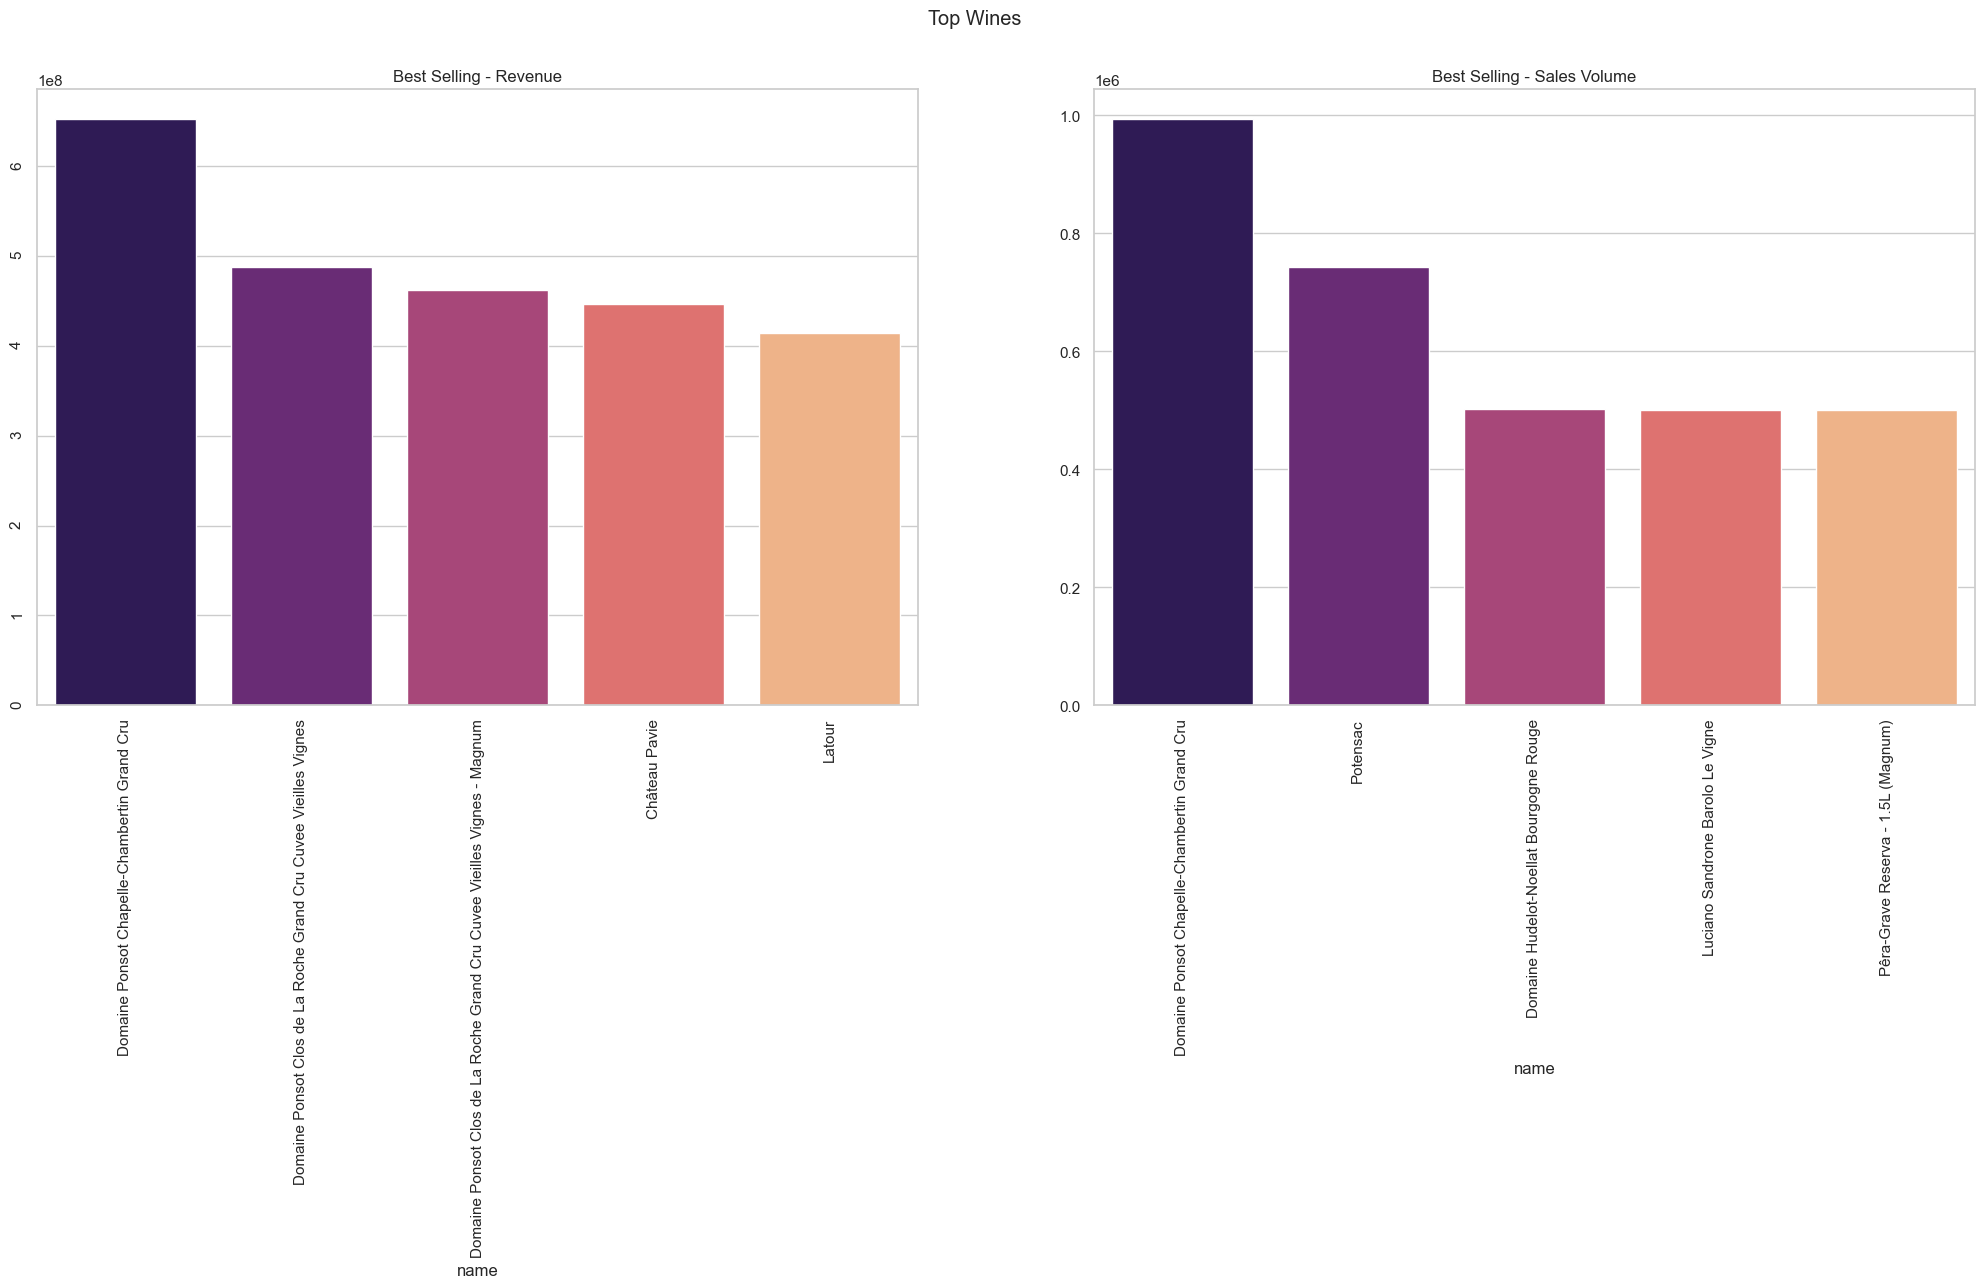

In [97]:
# visualizando os Top Sellers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (25,8))
fig.suptitle('Top Wines')

top_wines = store.groupby('name')['amount_spent'].sum().sort_values(ascending=False).iloc[0:5]
sns.barplot(x=top_wines.index, y=top_wines.values, palette="magma", ax=ax[0])
ax[0].tick_params(labelrotation=90)
ax[0].set_title('Best Selling - Revenue')

top_sales = store.groupby('name')['sales'].sum().sort_values(ascending=False).iloc[0:5]
sns.barplot(x=top_sales.index, y=top_sales.values, palette="magma")
plt.xticks(rotation=90)
ax[1].set_title('Best Selling - Sales Volume')

plt.show()

Podemos observar que o vinho com maior volume de vendas é aquele que traz maior receita. Agora plotarei um gráfico de linhas para a quantia vendida e a quantidade de vendas por ano.

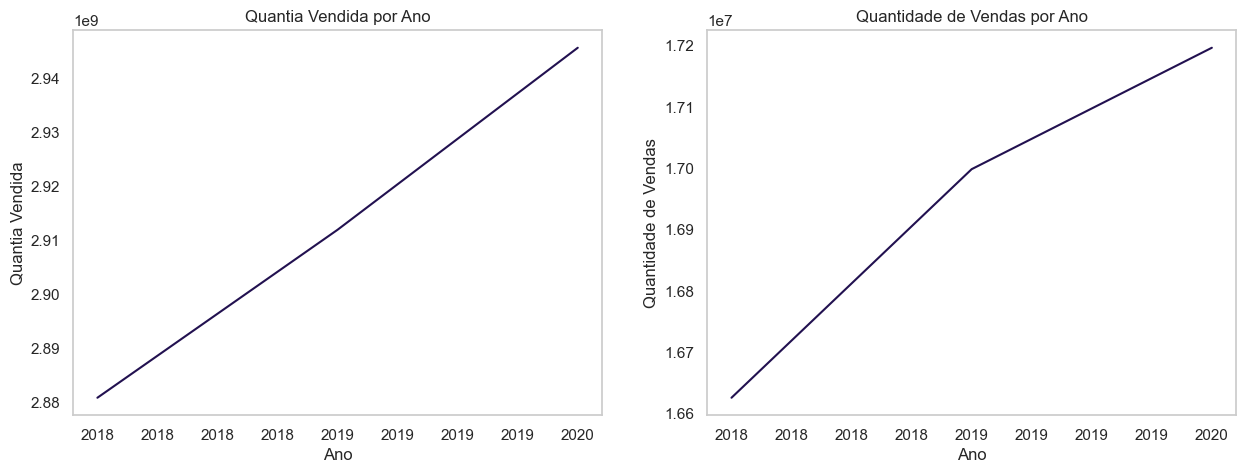

In [98]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

sns.set(style="whitegrid", palette = 'magma')

sns.lineplot(x=store.groupby('Year')['amount_spent'].sum().index, y=store.groupby('Year')['amount_spent'].sum().values, ax=ax[0])
sns.lineplot(x=store.groupby('Year')['sales'].sum().index, y=store.groupby('Year')['sales'].sum().values, ax=ax[1])

for i in range (0, 2):
    ax[i].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax[i].grid(False)
    
ax[0].set(xlabel='Ano', ylabel='Quantia Vendida')
ax[0].set_title("Quantia Vendida por Ano")

ax[1].set(xlabel='Ano', ylabel='Quantidade de Vendas')
ax[1].set_title("Quantidade de Vendas por Ano")
plt.show()

Pode-se observar que tanto a quantida vendida, como a quantidade de vendas aumentam anualmente.

Irei plotar um gráfico de barras que irá comparar a quantidade de vendas em proporção em finais de semana e dias úteis.

In [99]:
total_sales = store['amount_spent'].sum()
weekend_sales = store.groupby('Weekend')['amount_spent'].sum()  
weekend_proportion = round(weekend_sales / total_sales * 100,2)

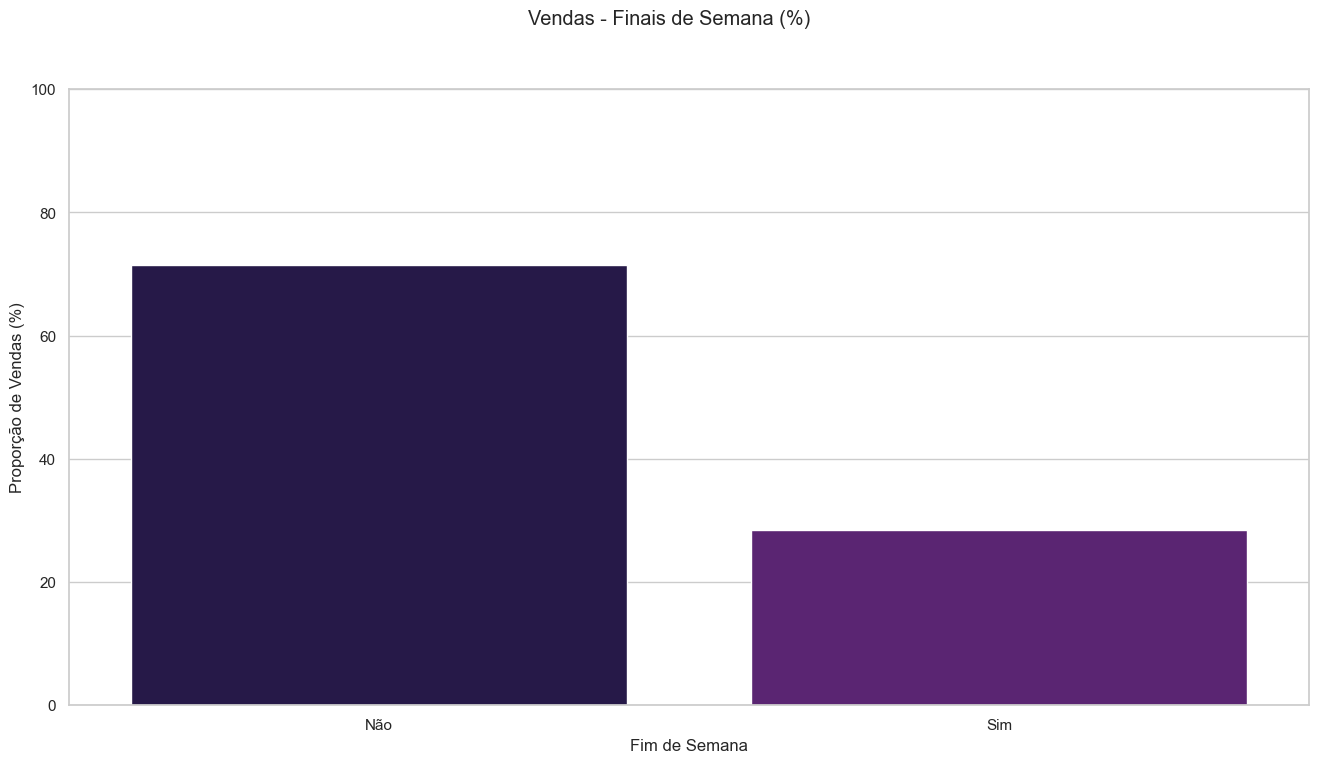

In [100]:
# criar um novo DataFrame com as informações de proporção de vendas
weekend_df = pd.DataFrame({'Weekend': ['Não', 'Sim'], 'Proporção de Vendas': weekend_proportion})

# plotar o gráfico de barras
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='Weekend', y='Proporção de Vendas', data=weekend_df, ax=ax)

# configurar os eixos e título do gráfico
ax.set_ylabel('Proporção de Vendas (%)')
ax.set_xlabel('Fim de Semana')
ax.set_ylim([0, 100])
fig.suptitle('Vendas - Finais de Semana (%)')

# exibir o gráfico
plt.show()

71.48% das vendas ocorrem nos dias úteis e 28.52% nos finais de semana.

## Previsão de Demanda - Facebook Prophet

Após analisar nosso conjunto de dados, vamos realizar previsões com o `Prophet`, desenvolvido pelo Facebook. Ele é robusto, simples e fácil de usar.

### Testes Estatísticos e ARIMA
Para prever uma Série Temporal (TS), ela deve ser estacionária, ou seja, ter média, variância e covariância constantes ao longo do tempo.

**Verificação da estacionaridade de uma TS:**

* Análise visual - Identifique estacionaridade durante a análise exploratória.
* Resumo estatístico - Verifique indícios de estacionaridade nas informações estatísticas.
* Testes estatísticos - Utilize métodos científicos, como o Augmented Dickey Fuller (ADF).
* Teste ADF - O teste ADF é comum para TS. As hipóteses são:

* - Hipótese Nula ($H_0$) - A TS não é estacionária, possui dependência temporal.
* - Hipótese Alternativa ($H_1$) - A TS é estacionária.

Aplicaremos o teste ADF neste projeto.


É necessário preparar os dados para serem utilizados com o Prophet. Ele precisa de um tipo muito específico de dataframe para funcionar. Precisamos de:

* Data como uma coluna chamada `ds`.
* Vendas como uma coluna chamada `y`.


In [101]:
# preparando o dataset
df_ts= store.groupby('Date',as_index=False)['sales'].sum()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.index = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.drop('Date', axis=1, inplace=True)

# nomeando corretamente
df_ts = df_ts.reset_index()
df_ts.columns = ['ds', 'y']
df_ts.head()

,ds,y
0,2018-01-01,43432
1,2018-01-02,43181
2,2018-01-03,43298
3,2018-01-04,42216
4,2018-01-05,42001


### Teste ADF

In [102]:
# importanto o pacote
from statsmodels.tsa.stattools import adfuller
# extraindo os valores
X = df_ts.y

# aplicando o ADF e imprimindo os resultados.
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -2.3601
P Value: 0.1533303754
Critical Values:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682


O teste **Augmented Dickey-Fuller (ADF) é utilizado para verificar se uma Série Temporal é estacionária**. Ele fornece um valor estatístico e um valor-p para realizar essa verificação.

Neste caso:

* Estatística do teste: -2.3601
* Valor-p: 0.1533303754
* Valores críticos:
* 1%: -3.4365
* 5%: -2.8642
* 10%: -2.5682

A interpretação do teste ADF se dá através do valor-p e dos valores críticos. Se o valor-p for menor que um determinado nível de significância, rejeitamos a hipótese nula ($H_0$) e concluímos que a série é estacionária.

Neste exemplo, o valor-p é 0.1533, que é maior que 0.05. Portanto, não rejeitamos a hipótese nula, indicando que **a série não é estacionária**.

### Transformando a Série em Estacionária

Para transformar uma TS em estacionária, precisamos remover a tendência e a sazonalidade que há nos dados originais. Para isso, existem diversas técnicas que podem ser usadas. Aqui, será aplicado $log$ a fim de reduzirmos a magnitude dos valores da TS. Na sequência, subtraímos a média móvel de um determinado período em relação ao $log$ da TS.

In [103]:
# preparando os dados
df_ts.index = pd.to_datetime(df_ts['ds'], format="%Y-%m-%d")
df_ts.drop('ds', axis=1, inplace=True)
df_ts.head()

,y
ds,
2018-01-01,43432
2018-01-02,43181
2018-01-03,43298
2018-01-04,42216
2018-01-05,42001


Iremos plotar série temporal original e sua média móvel (janela de 24 pontos) para visualizar a tendência e a sazonalidade.

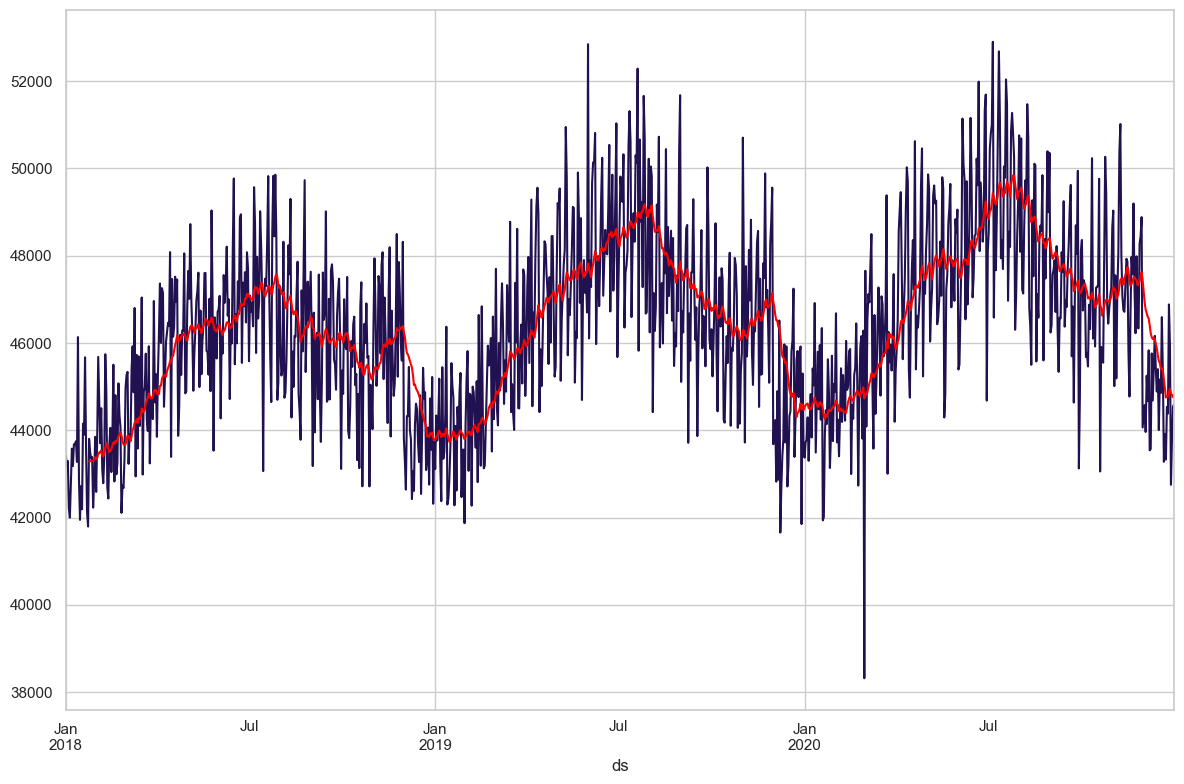

In [104]:
# checando o plot original
ma = df_ts.rolling(24).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_ts.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout();

Agora será aplicado transformação logarítmica aos dados, o que ajuda a reduzir a magnitude dos valores e estabilizar a variância. A transformação logarítmica é uma técnica comum para lidar com séries temporais que apresentam crescimento exponencial ou mudanças abruptas.

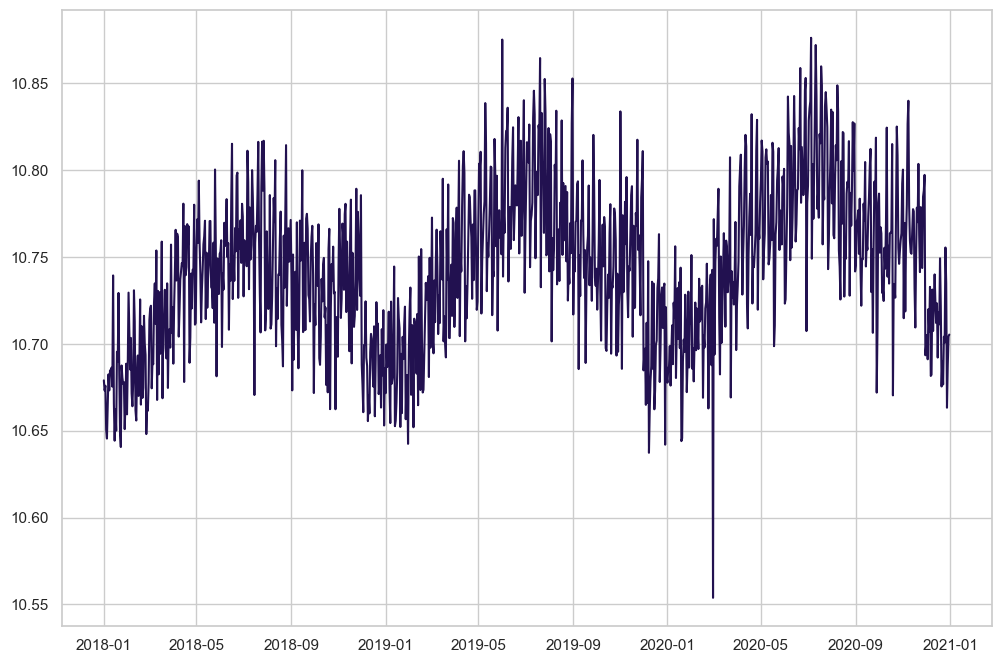

In [105]:
# aplicando o log
fig, ax = plt.subplots(figsize=(12,8))
ts_log = np.log(df_ts)
plt.plot(ts_log);

Irei calcular a média móvel dos dados transformados (janela de 24 pontos) e plotar os resultados para verificar se a tendência foi atenuada.

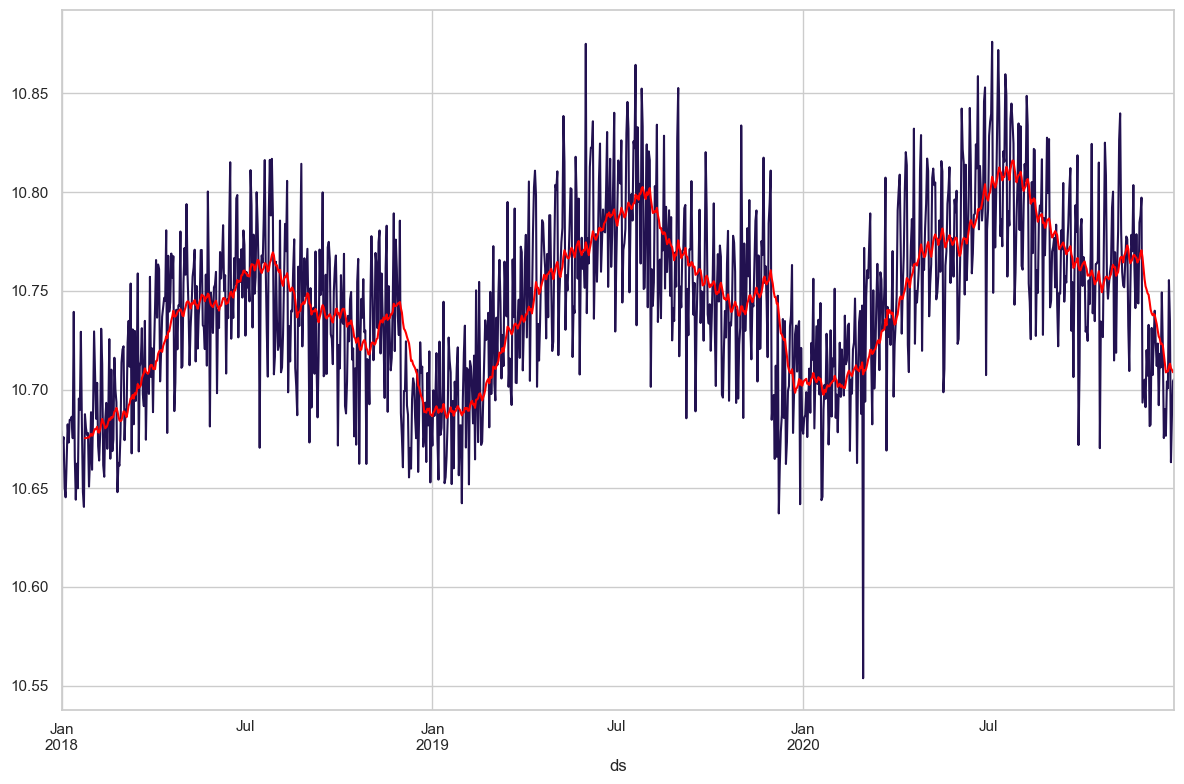

In [106]:
# aplicando o log
df_log = np.log(df_ts)
ma_log = df_log.rolling(24).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

Agora iremos subtrair a média móvel dos dados transformados, removendo a tendência e a sazonalidade da série temporal. Essa etapa é crucial para tornar a série estacionária. O gráfico resultante mostra a série temporal transformada, sua média móvel e o desvio padrão.

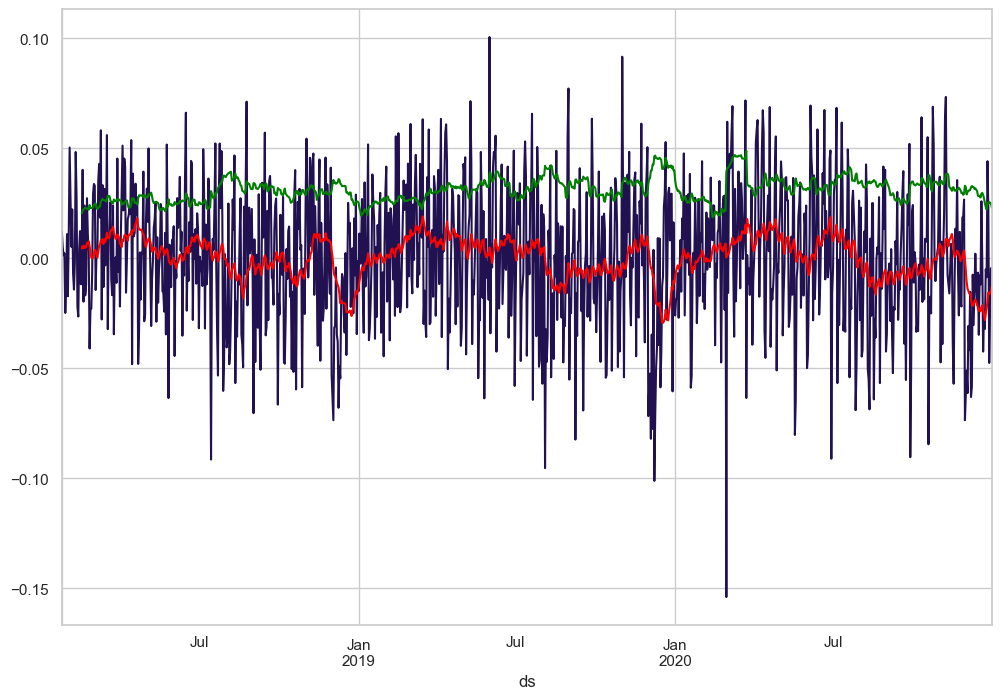

In [107]:
# subtraindo a média do log nos dados
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(24).mean()
std_sub = df_sub.rolling(24).std()

fig, ax = plt.subplots(figsize=(12,8))
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show();

In [108]:
# repetindo o ADF
X_sub = df_sub.y.values

# aplicando o ADF e imprimindo os resultados
result_sub = adfuller(X_sub)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -5.6436
P Value: 0.0000010231
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682


Neste novo exemplo do teste Augmented Dickey-Fuller (ADF), temos:

**Valores críticos**:

* 1%: -3.4366 (99% de confiança)
* 5%: -2.8643 (95% de confiança)
* 10%: -2.5682 (90% de confiança)

A estatística do teste (-5.6436) é menor que todos os valores críticos. Isso significa que podemos rejeitar a **hipótese nula ($H_0$) com 99% de confiança, concluindo que a série é estacionária**.

## Previsão com Prophet

O código apresentado tem como objetivo preparar os dados para serem usados no modelo Prophet para fazer previsões futuras. Defini o o tamanho da previsão como 30 dias.

In [109]:
# transformando no formato do Prophet
df_log.reset_index(inplace=True)

# definindo o tamanho da previsão
prediction_size = 30
train_df = df_log[:-prediction_size]

Agora iremos instanciar o modelo e fazer previsões.

In [110]:
# instanciando o modelo
prophet = Prophet()

# treinando o modelo
prophet.fit(train_df)

# fazer previsões
future = prophet.make_future_dataframe(periods=prediction_size)

forecast = prophet.predict(future)

forecast.head()

22:59:48 - cmdstanpy - INFO - Chain [1] start processing
22:59:49 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,10.727337,10.625121,10.693315,10.727337,10.727337,-0.068090,-0.068090,-0.068090,-0.019148,-0.019148,-0.019148,-0.048942,-0.048942,-0.048942,0.0,0.0,0.0,10.659247
1,2018-01-02,10.727298,10.631885,10.699556,10.727298,10.727298,-0.062009,-0.062009,-0.062009,-0.012998,-0.012998,-0.012998,-0.049012,-0.049012,-0.049012,0.0,0.0,0.0,10.665289
2,2018-01-03,10.727260,10.638834,10.706703,10.727260,10.727260,-0.054704,-0.054704,-0.054704,-0.005592,-0.005592,-0.005592,-0.049112,-0.049112,-0.049112,0.0,0.0,0.0,10.672556
3,2018-01-04,10.727221,10.648416,10.718636,10.727221,10.727221,-0.044450,-0.044450,-0.044450,0.004786,0.004786,0.004786,-0.049236,-0.049236,-0.049236,0.0,0.0,0.0,10.682771
4,2018-01-05,10.727182,10.663510,10.730167,10.727182,10.727182,-0.031107,-0.031107,-0.031107,0.018272,0.018272,0.018272,-0.049379,-0.049379,-0.049379,0.0,0.0,0.0,10.696075


A feature `yhat` é referente às previsões. Além disso temos também os limites inferiores e superiores (`yhat_lower`, `yhat_upper`, respectivamente).

Iremos plotar as previsões abaixo de maneira **interativa**.

In [111]:
pyo.init_notebook_mode(connected=True)
fig = plot_plotly(prophet, forecast)
pyo.iplot(fig)

### Métricas de desempenho

Com o treino realizado, iremos calcular as métricas de desempenho usando os dados de treinamento e previsão.

In [112]:
test_df = df_log[-prediction_size:]
y_pred = forecast['yhat'][-prediction_size:].values
y_true = test_df['y'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)


MAE:  0.021640439183469695
MSE:  0.0005974337045542944
RMSE:  0.024442457007311978


O erro é baixo, o que indica bons resultados. O MAE é a média das diferenças absolutas entre os valores previstos e os valores reais. É uma medida fácil de entender e interpretar, pois tem a mesma unidade que os dados. Um MAE de 0.0216 indica que, em média, as previsões do modelo estão a 0.0216 unidades de distância dos valores reais. O MSE é a média das diferenças quadráticas entre os valores previstos e os valores reais. Ele dá mais peso aos erros maiores, pois os erros são elevados ao quadrado antes de serem calculados. O RMSE é a raiz quadrada do MSE. Ele tem a mesma unidade que os dados e os erros e é uma medida comumente usada para avaliar o desempenho de modelos de previsão. Um RMSE de 0.0244 indica que, em média, as previsões do modelo estão a 0.0244 unidades de distância dos valores reais. 

Contudo os valores estão em log, devemos trazê-los de volta fazendo uma transformação exponencial.


In [113]:
# criando um dataset e verificando as predições
df_final = forecast[['ds', 'yhat']]
df_final.head()
df_final['AmountSpentLog'] = df_log['y']
df_final.head()

,ds,yhat,AmountSpentLog
0,2018-01-01,10.659247,10.678952
1,2018-01-02,10.665289,10.673156
2,2018-01-03,10.672556,10.675862
3,2018-01-04,10.682771,10.650555
4,2018-01-05,10.696075,10.645449


Agora vamos criar um dataset que contenha:

* Data (`ds`)
* Previsão do Prophet (`yhat`)
* Valor Gasto Real (`AmountSpent`)
* Valor Gasto Previsto na escala correta (`AmountSpentPred`)

In [114]:
# getting the values back to their original scale
df_final['AmountSpent'] = np.exp(df_final['AmountSpentLog'].values)
df_final['AmountSpentPred'] = np.exp(df_final['yhat'].values)
df_final.head(10)

,ds,yhat,AmountSpentLog,AmountSpent,AmountSpentPred
0,2018-01-01,10.659247,10.678952,43432.0,42584.550180
1,2018-01-02,10.665289,10.673156,43181.0,42842.632092
2,2018-01-03,10.672556,10.675862,43298.0,43155.106131
3,2018-01-04,10.682771,10.650555,42216.0,43598.184986
4,2018-01-05,10.696075,10.645449,42001.0,44182.121135
5,2018-01-06,10.707704,10.663522,42767.0,44698.909204
6,2018-01-07,10.661999,10.682400,43582.0,42701.915520
7,2018-01-08,10.658067,10.673179,43182.0,42534.354233
8,2018-01-09,10.664030,10.684646,43680.0,42788.721930
9,2018-01-10,10.671262,10.684783,43686.0,43099.282740


Iremos plotar as predições e a realidade.

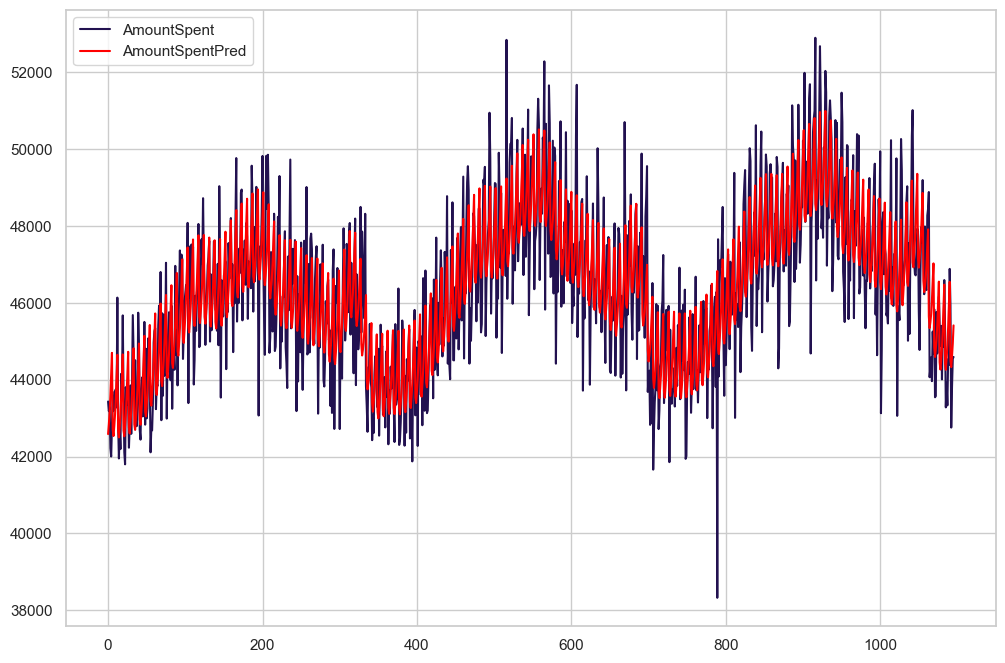

In [115]:
# plotting predictions vs reality
fig, ax = plt.subplots(figsize=(12,8))
df_final['AmountSpent'].plot(ax=ax, legend=('Amount Spent'))
df_final['AmountSpentPred'].plot(ax=ax, color='r', legend={'Predicted'})
plt.savefig('st_yhat.png')
plt.show()


Agora vamos calcular as métricas de desempenho na escala original. Obviamente, os valores estão maiores, mas de modo geral o modelo é satisfatório.

In [116]:
y_pred_original = df_final['AmountSpentPred'][-prediction_size:].values
y_true_original = df_final['AmountSpent'][-prediction_size:].values

mae_original = mean_absolute_error(y_true_original, y_pred_original)
mse_original = mean_squared_error(y_true_original, y_pred_original)
rmse_original = np.sqrt(mse_original)

print("MAE (original scale): ", mae_original)
print("MSE (original scale): ", mse_original)
print("RMSE (original scale): ", rmse_original)

MAE (original scale):  971.8768681133299
MSE (original scale):  1206242.8253871247
RMSE (original scale):  1098.2908655666424


### Conclusão

Este projeto demonstra como aplicar **técnicas de análise de séries temporais** e utilizar o pacote **Prophet para prever a demanda de vinhos**. Para o mesmo, os seguintes passos foram realizados:

* Importação e exploração dos dados: Carregamento dos dados, verificação das informações básicas e visualização da série temporal de vendas de vinhos.
* Transformação dos dados: Aplicação de uma transformação logarítmica nos dados para tornar a série temporal mais estacionária.
* Criação e treinamento do modelo: Utilização do pacote Prophet do Facebook para criar e treinar um modelo de previsão de séries temporais.
* Previsão e avaliação: Realização de previsões para um período futuro e cálculo de várias métricas de desempenho, como MAE, MSE e RMSE, tanto na escala logarítmica quanto na escala original.
* Visualização dos resultados: Exibição dos resultados das previsões e comparação com os valores reais.

Com base nas métricas de desempenho calculadas, o modelo Prophet teve um bom desempenho na previsão da demanda de vinhos.